# Unsupervised Anomaly Detection in Time Series of Bank Transactions

## 1. Data Cleaning & Exploratory Data Analysis

In [1]:
# Data and Stats Packages
import pandas as pd
import numpy as np
import re
import datetime as dt

# Visualization Packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Anomaly Detection Packages
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings("ignore")

In [2]:
bank = pd.read_excel('Sample_bank_transaction_data.xlsx')
bank_raw = bank.copy()

In [3]:
bank.head()

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [4]:
bank.shape

(116201, 9)

In [5]:
bank.describe()

,CHQ.NO.,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT
count,905.000000,5.354900e+04,6.265200e+04,1.162010e+05
mean,791614.503867,4.489190e+06,3.806586e+06,-1.404852e+09
std,151205.932910,1.084850e+07,8.683093e+06,5.348202e+08
min,1.000000,1.000000e-02,1.000000e-02,-2.045201e+09
25%,704231.000000,3.000000e+03,9.900000e+04,-1.690383e+09
50%,873812.000000,4.708300e+04,4.265000e+05,-1.661395e+09
75%,874167.000000,5.000000e+06,4.746411e+06,-1.236888e+09
max,874525.000000,4.594475e+08,5.448000e+08,8.500000e+06


In [6]:
bank.columns

Index(['Account No', 'DATE', 'TRANSACTION DETAILS', 'CHQ.NO.', 'VALUE DATE',
       'WITHDRAWAL AMT', 'DEPOSIT AMT', 'BALANCE AMT', '.'],
      dtype='object')

In [7]:
bank.rename(columns={'Account No': 'account_no', 'DATE':'date', 'TRANSACTION DETAILS':'details', 'CHQ.NO.':'chq_no', 'VALUE DATE':'value_date',
       'WITHDRAWAL AMT':'withdrawal_amt', 'DEPOSIT AMT':'deposit_amt', 'BALANCE AMT':'balance_amt'}, inplace=True)
bank.head(3)

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.


We have a time series data without anomaly labeling. Let's take a closer look at the features.

In [8]:
def first_look(df, col):
    """
    Enables a quick search for characteristics of a column in a data frame.
    
    df: Data Frame
    col: Column of interest
    
    """
    val = pd.DataFrame(df[col].value_counts(dropna=False))
    val = val.assign(percent=(df[col].value_counts(dropna=False, normalize=True).values)*100)
    info = pd.DataFrame({'Column_Name': [col],'Null_Rows': [df[col].isna().sum()], 'Column_Type': [df[col].dtypes]}, index=['column_info'])
    return info, val

### i. account_no

In [9]:
info , val = first_look(bank, bank.columns[0])

In [10]:
info

,Column_Name,Null_Rows,Column_Type
column_info,account_no,0,object


In [11]:
val

,account_no,percent
1196428',48779,41.978124
409000362497',29840,25.679641
409000438620',13454,11.578214
1196711',10536,9.067048
409000493210',6014,5.175515
409000438611',4588,3.948331
409000611074',1093,0.940612
409000493201',1044,0.898443
409000425051',802,0.690183
409000405747',51,0.043889


Since **account_no** is a unique indicator of customers (in our case we have 10 customers who have rather unbalanced transaction frequencies), we should keep the data type as string and for future investigation purposes we will remove the **'** (last character).

In [12]:
bank['account_no'] = bank.account_no.str.extract(r'(\d+)\'')

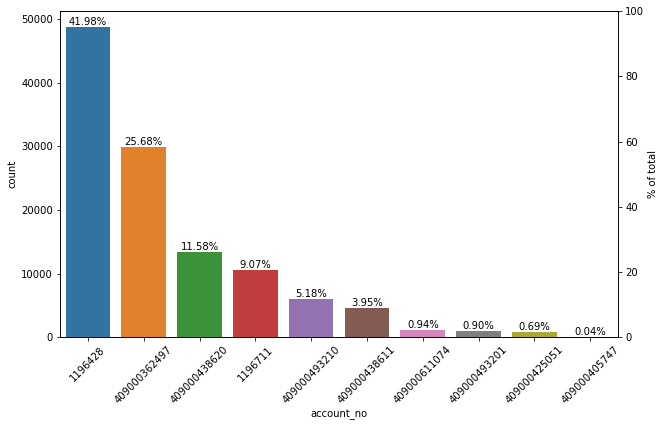

In [13]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
fig = sns.countplot(data=bank, x='account_no', order=bank.account_no.value_counts().index)
fig2 = fig.twinx()

fig.yaxis.set_label_position('left')
fig2.yaxis.set_label_position('right')

fig2.set_ylabel('% of total')

for p in fig.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    fig.annotate('{:.2f}%'.format(100.*y/len(bank)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
fig2.grid(None)
fig2.set_ylim(0,100)
fig2.grid()
plt.show()

### ii. date

In [14]:
info , val = first_look(bank, bank.columns[1])

In [15]:
info

,Column_Name,Null_Rows,Column_Type
column_info,date,0,datetime64[ns]


In [16]:
bank.date.apply(lambda x: x.year).value_counts()

2018    35534
2016    30372
2017    29113
2015    15658
2019     5524
Name: date, dtype: int64

In [17]:
((bank.date).dt.dayofweek).value_counts()

0    22662
4    22058
1    21561
3    20446
2    19421
5     9830
6      223
Name: date, dtype: int64

In [18]:
conditions = [((bank.date).dt.dayofweek  > 4), ((bank.date).dt.dayofweek  < 5)]
values = [1, 0]
bank['weekend_date'] = np.select(conditions, values)

### iii. details

In [19]:
info , val = first_look(bank, bank.columns[2])

In [20]:
info

,Column_Name,Null_Rows,Column_Type
column_info,details,2499,object


In [21]:
bank[bank.details.isna()].account_no.value_counts()

409000362497    2484
1196711           15
Name: account_no, dtype: int64

In [22]:
bank[bank.details.isna()].date.apply(lambda x: x.year).value_counts()

2015    1259
2016    1240
Name: date, dtype: int64

In [23]:
bank.details.sample(10)

49822                       CASHDEP/DAMAN/
102226                 IMPS OW 27022017 2C
98753         RTGS/SBINH16299930239/Indfor
93961            VSERV DIGITAL SERVICES PR
13898      Indiaforensic AEPS NPCI WDL SET
17447          CR720118137110/RMCPL10371/2
76760         NEFT/N176180570033885/Indfor
100403    Indiaforensic SERVICES INDIA PVT
79418            CHQ DEP/614541/OWDEL1/SBI
115226                       IMPS 0412184C
Name: details, dtype: object

This function has the potential to provide information about anomalies. It could help us find new features. For starters, let's define a column that indicates whether a transaction has no proper details value (Null or nonsense values).

In [24]:
conditions = [(bank.details.isna())]
values = [1]
bank['details_null_penalty'] = np.select(conditions, values)

In [25]:
conditions = [(bank.details.str.extract(r'(\w+)')[0].isna())]
values = [1]
bank['details_numbers_penalty'] = np.select(conditions, values)

In [26]:
bank.details_null_penalty.value_counts()

0    113702
1      2499
Name: details_null_penalty, dtype: int64

In [27]:
bank.details_numbers_penalty.value_counts()

0    112050
1      4151
Name: details_numbers_penalty, dtype: int64

This penalty is not a red flag by itself, but can be an additional checkpoint for the anomaly detection results. Let's leave the **details** column at this point and move on to the next feature.

### iv. chq_no

In [28]:
info , val = first_look(bank, bank.columns[3])

In [29]:
info

,Column_Name,Null_Rows,Column_Type
column_info,chq_no,115296,float64


In [30]:
val

,chq_no,percent
NaN,115296,99.221177
3.0,3,0.002582
2.0,3,0.002582
4.0,3,0.002582
5.0,3,0.002582
...,...,...
874018.0,1,0.000861
874017.0,1,0.000861
874015.0,1,0.000861
874014.0,1,0.000861


In [31]:
bank[bank.chq_no<10]

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.,weekend_date,details_null_penalty,details_numbers_penalty
2907,409000425051,2017-06-12,Indiaforensic SERVICES INDIA PVT,1.0,2017-06-12,200.0,NaN,6.010878e+05,.,0,0,0
2908,409000425051,2017-06-12,Indiaforensic SERVICES I P LTD F,2.0,2017-06-12,200.0,NaN,6.008878e+05,.,0,0,0
2909,409000425051,2017-06-12,Indiaforensic SERVICES I P LTD P,5.0,2017-06-12,200.0,NaN,6.006878e+05,.,0,0,0
2910,409000425051,2017-06-12,Indiaforensic SERVICES INDIA PVT,6.0,2017-06-12,200.0,NaN,6.004878e+05,.,0,0,0
2911,409000425051,2017-06-12,Indiaforensic SERVICES I P LTD R,4.0,2017-06-12,200.0,NaN,6.002878e+05,.,0,0,0
2912,409000425051,2017-06-12,Indiaforensic SERVICES I P LTD R,3.0,2017-06-12,200.0,NaN,6.000878e+05,.,0,0,0
2913,409000425051,2017-06-14,Indiaforensic SERVICES INDIA PVT,9.0,2017-06-14,200.0,NaN,5.998878e+05,.,0,0,0
2914,409000425051,2017-06-14,Indiaforensic SERVICES INDIA PVT,7.0,2017-06-14,200.0,NaN,5.996878e+05,.,0,0,0
2915,409000425051,2017-06-14,Indiaforensic SERVICES INDIA PVT,8.0,2017-06-14,200.0,NaN,5.994878e+05,.,0,0,0
5654,409000438611,2018-06-25,NEFT/000041992898/Indiaforensic,2.0,2018-06-25,5000000.0,NaN,-5.325215e+08,.,0,0,0


In [32]:
bank[~bank.chq_no.isna()].sample(10)

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.,weekend_date,details_null_penalty,details_numbers_penalty
36620,1196711,2017-06-06,NEFT/000016693683/Indiaforensic,874420.0,2017-06-06,15000000.00,NaN,-1.518392e+09,.,0,0,0
29460,1196711,2015-09-25,HACHETTE BOOK PUBLISHING,873877.0,2015-09-25,107880.00,NaN,-1.524739e+09,.,0,0,0
81273,1196428,2018-09-27,CASHPMT/GURGAON/SELF,704248.0,2018-09-27,49000.00,NaN,-1.690270e+09,.,0,0,0
32994,1196711,2016-04-04,SHRI RAM SAHU,874294.0,2016-04-04,2000.00,NaN,-1.282338e+09,.,0,0,0
33190,1196711,2016-04-13,AAB ENTERPRISES,874322.0,2016-04-13,1190.00,NaN,-1.523579e+09,.,0,0,0
28086,1196711,2015-08-13,TRESOR SYSTEMS PRIVATE LT,873633.0,2015-08-13,105583.04,NaN,-1.137682e+09,.,0,0,0
51792,1196428,2016-06-08,RTGS/YESBH16160333961/Indfor,704007.0,2016-06-08,15000000.00,NaN,-1.710485e+09,.,0,0,0
33395,1196711,2016-04-22,VODAFONE MOBILE SERVICES,874495.0,2016-04-22,11450.00,NaN,-1.552413e+09,.,0,0,0
30447,1196711,2015-11-03,CHANDER SAINI,874096.0,2015-11-03,100000.00,NaN,-1.549383e+09,.,0,0,0
54776,1196428,2016-08-26,RTGS/YESBH16239597202/Indfor,704133.0,2016-08-26,15000000.00,NaN,-1.743800e+09,.,0,0,0


In [33]:
bank[bank.chq_no<100000].tail()

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.,weekend_date,details_null_penalty,details_numbers_penalty
22220,409000438620,2018-06-27,RTGS/YESBH18178695745/Indfor,8.0,2018-06-27,10000000.0,NaN,-5.462546e+08,.,0,0,0
22245,409000438620,2018-06-28,RTGS/YESBH18179801413/Indfor,10.0,2018-06-28,1900000.0,NaN,-5.312736e+08,.,0,0,0
22247,409000438620,2018-06-28,RTGS/YESBH18179801622/Indfor,9.0,2018-06-28,15000000.0,NaN,-5.462736e+08,.,0,0,0
37589,1196428,2015-01-02,RTGS/YESBH15002745737/Indfor,4549.0,2015-01-02,5500000.0,NaN,-1.590326e+09,.,0,0,0
37593,1196428,2015-01-03,FUND TRF TO Indiaforensic SERVI,4550.0,2015-01-03,2200000.0,NaN,-1.590153e+09,.,1,0,0


In [34]:
bank['cheque_penalty'] = np.where(bank.chq_no<11, 1, 0)

In [35]:
bank.cheque_penalty.value_counts()

0    116180
1        21
Name: cheque_penalty, dtype: int64

Again, this penalty is not a red flag in itself, but on the other hand, given the incorrect check numbers, it can be an additional check point for the anomaly detection results. Let's leave the **chq_no** column at this point and move on to the next feature.

### v. value_date

In [36]:
info , val = first_look(bank, bank.columns[4])

In [37]:
info

,Column_Name,Null_Rows,Column_Type
column_info,value_date,0,datetime64[ns]


In [38]:
bank['day_diff'] = ((bank.date - bank.value_date) / np.timedelta64(1,'D')).astype(int)

In [39]:
bank.day_diff.value_counts()

 0     116066
 1         86
 3         15
 2         11
 5          9
 4          8
 29         2
-1          1
 18         1
 8          1
 6          1
Name: day_diff, dtype: int64

In [40]:
bank[(bank.day_diff < 0) | (bank.day_diff > 5)]

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.,weekend_date,details_null_penalty,details_numbers_penalty,cheque_penalty,day_diff
63340,1196428,2017-05-16,FT ZL1705177BD415D1 SHREE,NaN,2017-05-17,NaN,50000.00,-1.657087e+09,.,0,0,0,0,-1
63717,1196428,2017-06-06,Payments For : 9090000405,NaN,2017-05-31,657534.00,NaN,-1.689498e+09,.,0,0,0,0,6
103332,409000362497,2017-04-05,REPAYMENT CREDIT [7090021,NaN,2017-03-07,NaN,4812379.15,-1.831388e+09,.,0,0,0,0,29
103335,409000362497,2017-04-05,Sweep Trf To: 40900036427,NaN,2017-03-07,7952045.15,NaN,-1.842516e+09,.,0,0,0,0,29
104111,409000362497,2017-05-05,FD BOOKING 365 DAYS DEPO,NaN,2017-04-27,58500000.00,NaN,-1.902886e+09,.,0,0,0,0,8
112081,409000362497,2018-04-27,Sweep Trf To: 40900036427,NaN,2018-04-09,9176351.00,NaN,-1.886386e+09,.,0,0,0,0,18


As one could obviously see, we have obtained an important feature that we will look at more closely in the anomaly analysis. Let's have a quick look whether we have weekend value_dates.

In [41]:
((bank.value_date).dt.dayofweek  > 4).value_counts()

False    106146
True      10055
Name: value_date, dtype: int64

In [42]:
conditions = [((bank.value_date).dt.dayofweek  > 4), ((bank.value_date).dt.dayofweek  < 5)]
values = [1, 0]
bank['weekend_value_date'] = np.select(conditions, values)

### vi. withdrawal_amt

In [43]:
info , val = first_look(bank, bank.columns[5])

In [44]:
info

,Column_Name,Null_Rows,Column_Type
column_info,withdrawal_amt,62652,float64


In [45]:
bank.withdrawal_amt.describe()

count    5.354900e+04
mean     4.489190e+06
std      1.084850e+07
min      1.000000e-02
25%      3.000000e+03
50%      4.708300e+04
75%      5.000000e+06
max      4.594475e+08
Name: withdrawal_amt, dtype: float64

In [46]:
bank[~bank.withdrawal_amt.isna()].count()

account_no                 53549
date                       53549
details                    53549
chq_no                       905
value_date                 53549
withdrawal_amt             53549
deposit_amt                    0
balance_amt                53549
.                          53549
weekend_date               53549
details_null_penalty       53549
details_numbers_penalty    53549
cheque_penalty             53549
day_diff                   53549
weekend_value_date         53549
dtype: int64

In [47]:
bank[bank.withdrawal_amt.isna()].count()

account_no                 62652
date                       62652
details                    60153
chq_no                         0
value_date                 62652
withdrawal_amt                 0
deposit_amt                62652
balance_amt                62652
.                          62652
weekend_date               62652
details_null_penalty       62652
details_numbers_penalty    62652
cheque_penalty             62652
day_diff                   62652
weekend_value_date         62652
dtype: int64

In [48]:
pd.DataFrame(bank.groupby('account_no').withdrawal_amt.count()).sort_values('withdrawal_amt', ascending=False)

,withdrawal_amt
account_no,
1196428,16687
409000362497,15477
409000438620,8391
409000493210,5227
1196711,5025
409000438611,1333
409000611074,778
409000493201,575
409000405747,28


In [49]:
conditions = [((bank.balance_amt+bank.withdrawal_amt)==0), ((bank.balance_amt+bank.withdrawal_amt)!=0)]
values = [0, 100*(bank.withdrawal_amt/(bank.balance_amt+bank.withdrawal_amt))]
bank['withdrawal_over_balance'] = np.select(conditions, values)

In [50]:
bank['withdrawal_amt'] = bank.withdrawal_amt.fillna(0)

In [51]:
bank['withdrawal_over_balance'] = bank.withdrawal_over_balance.fillna(0)

In [52]:
bank[bank.withdrawal_amt!=0].head()

,account_no,date,details,chq_no,value_date,withdrawal_amt,deposit_amt,balance_amt,.,weekend_date,details_null_penalty,details_numbers_penalty,cheque_penalty,day_diff,weekend_value_date,withdrawal_over_balance
10,409000611074,2017-08-16,INDO GIBL Indiaforensic STL01071,NaN,2017-08-16,133900.0,NaN,8366100.0,.,0,0,0,0,0,0,1.575294
11,409000611074,2017-08-16,INDO GIBL Indiaforensic STL02071,NaN,2017-08-16,18000.0,NaN,8348100.0,.,0,0,0,0,0,0,0.215154
12,409000611074,2017-08-16,INDO GIBL Indiaforensic STL03071,NaN,2017-08-16,5000.0,NaN,8343100.0,.,0,0,0,0,0,0,0.059894
13,409000611074,2017-08-16,INDO GIBL Indiaforensic STL04071,NaN,2017-08-16,195800.0,NaN,8147300.0,.,0,0,0,0,0,0,2.346849
14,409000611074,2017-08-16,INDO GIBL Indiaforensic STL05071,NaN,2017-08-16,81600.0,NaN,8065700.0,.,0,0,0,0,0,0,1.001559


### vii. deposit_amt

In [53]:
info , val = first_look(bank, bank.columns[6])

In [54]:
info

,Column_Name,Null_Rows,Column_Type
column_info,deposit_amt,53549,float64


In [55]:
bank.deposit_amt.describe()

count    6.265200e+04
mean     3.806586e+06
std      8.683093e+06
min      1.000000e-02
25%      9.900000e+04
50%      4.265000e+05
75%      4.746411e+06
max      5.448000e+08
Name: deposit_amt, dtype: float64

In [56]:
bank[~bank.deposit_amt.isna()].count()

account_no                 62652
date                       62652
details                    60153
chq_no                         0
value_date                 62652
withdrawal_amt             62652
deposit_amt                62652
balance_amt                62652
.                          62652
weekend_date               62652
details_null_penalty       62652
details_numbers_penalty    62652
cheque_penalty             62652
day_diff                   62652
weekend_value_date         62652
withdrawal_over_balance    62652
dtype: int64

In [57]:
bank[bank.deposit_amt.isna()].count()

account_no                 53549
date                       53549
details                    53549
chq_no                       905
value_date                 53549
withdrawal_amt             53549
deposit_amt                    0
balance_amt                53549
.                          53549
weekend_date               53549
details_null_penalty       53549
details_numbers_penalty    53549
cheque_penalty             53549
day_diff                   53549
weekend_value_date         53549
withdrawal_over_balance    53549
dtype: int64

In [58]:
pd.DataFrame(bank.groupby('account_no').deposit_amt.count()).sort_values('deposit_amt', ascending=False)

,deposit_amt
account_no,
1196428,32092
409000362497,14363
1196711,5511
409000438620,5063
409000438611,3255
409000493210,787
409000425051,774
409000493201,469
409000611074,315


In [59]:
bank[bank.deposit_amt.isna() & bank.withdrawal_amt.isna()].count()

account_no                 0
date                       0
details                    0
chq_no                     0
value_date                 0
withdrawal_amt             0
deposit_amt                0
balance_amt                0
.                          0
weekend_date               0
details_null_penalty       0
details_numbers_penalty    0
cheque_penalty             0
day_diff                   0
weekend_value_date         0
withdrawal_over_balance    0
dtype: int64

In [60]:
conditions = [((bank.balance_amt-bank.deposit_amt)==0), ((bank.balance_amt-bank.deposit_amt)!=0)]
values = [0, 100*(bank.deposit_amt/(bank.balance_amt-bank.deposit_amt))]
bank['deposit_over_balance'] = np.select(conditions, values)
bank['deposit_over_balance'] = bank.deposit_over_balance.fillna(0)

In [61]:
bank['deposit_amt'] = bank.deposit_amt.fillna(0)

### viii. balance_amt

In [62]:
info , val = first_look(bank, bank.columns[7])

In [63]:
info

,Column_Name,Null_Rows,Column_Type
column_info,balance_amt,0,float64


In [64]:
bank.balance_amt.describe()

count    1.162010e+05
mean    -1.404852e+09
std      5.348202e+08
min     -2.045201e+09
25%     -1.690383e+09
50%     -1.661395e+09
75%     -1.236888e+09
max      8.500000e+06
Name: balance_amt, dtype: float64

In [65]:
bank[bank.balance_amt.isna()].count()

account_no                 0
date                       0
details                    0
chq_no                     0
value_date                 0
withdrawal_amt             0
deposit_amt                0
balance_amt                0
.                          0
weekend_date               0
details_null_penalty       0
details_numbers_penalty    0
cheque_penalty             0
day_diff                   0
weekend_value_date         0
withdrawal_over_balance    0
deposit_over_balance       0
dtype: int64

### ix. Dropping Empty Column

In [66]:
info , val = first_look(bank, bank.columns[8])

In [67]:
info

,Column_Name,Null_Rows,Column_Type
column_info,.,0,object


In [68]:
val

,.,percent
.,116201,100.0


In [69]:
bank.drop(columns=['.'], inplace=True, axis=1)

In [70]:
bank_detailed = bank.copy()

In [71]:
bank = bank[['account_no', 'date', 'value_date', 'day_diff', 'weekend_date', 'weekend_value_date', 'withdrawal_amt', 'deposit_amt', 'balance_amt', 'withdrawal_over_balance', 'deposit_over_balance', 'details_null_penalty', 'details_numbers_penalty', 'cheque_penalty']]

In [72]:
bank.head()

,account_no,date,value_date,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,details_null_penalty,details_numbers_penalty,cheque_penalty
0,409000611074,2017-06-29,2017-06-29,0,0,0,0.0,1000000.0,1000000.0,0.0,0.000000,0,0,0
1,409000611074,2017-07-05,2017-07-05,0,0,0,0.0,1000000.0,2000000.0,0.0,100.000000,0,0,0
2,409000611074,2017-07-18,2017-07-18,0,0,0,0.0,500000.0,2500000.0,0.0,25.000000,0,0,0
3,409000611074,2017-08-01,2017-08-01,0,0,0,0.0,3000000.0,5500000.0,0.0,120.000000,0,0,0
4,409000611074,2017-08-16,2017-08-16,0,0,0,0.0,500000.0,6000000.0,0.0,9.090909,0,0,0


## 2. Data Visualization

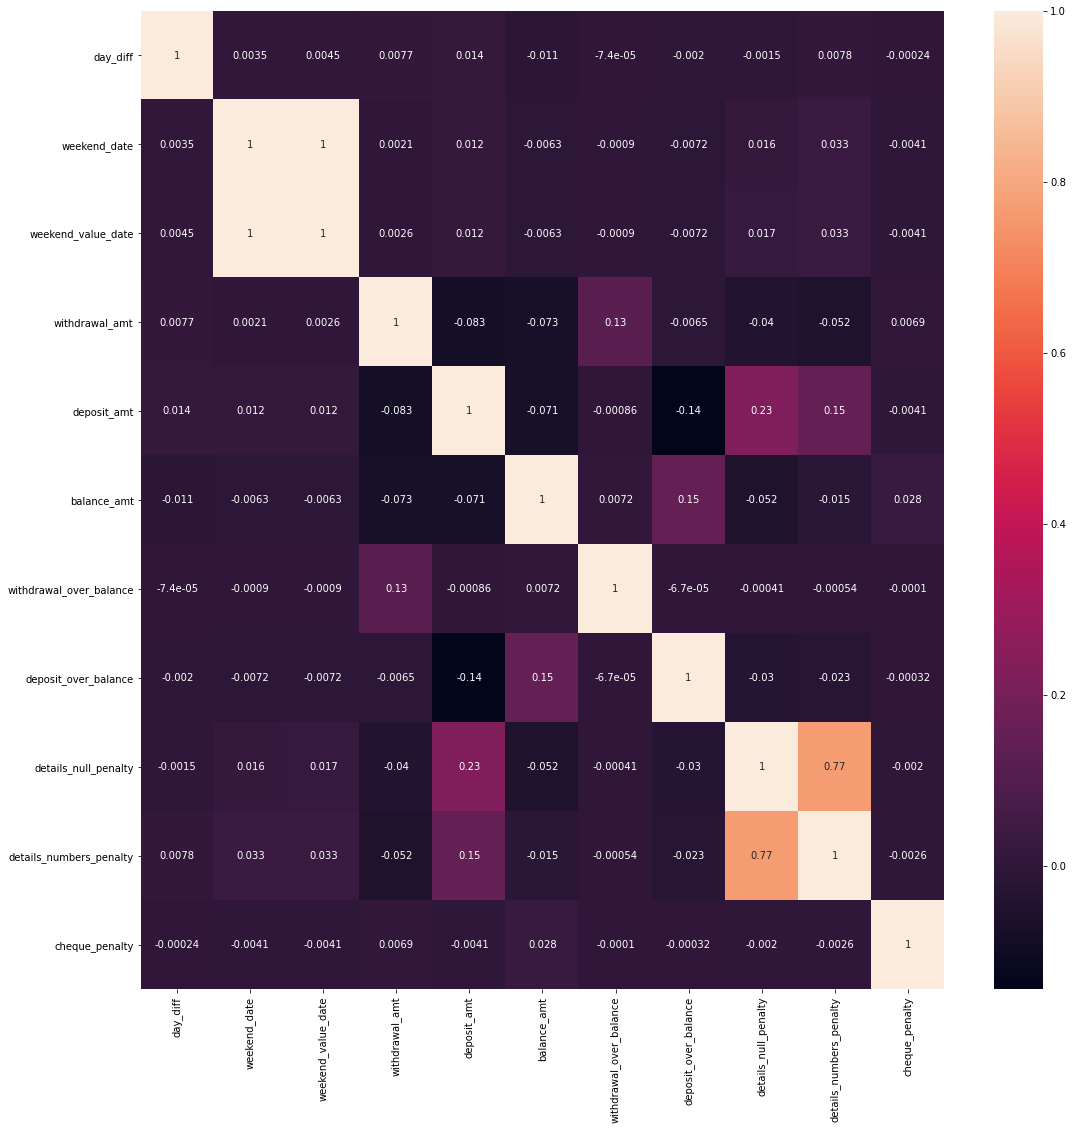

In [73]:
plt.figure(figsize=(18, 18))
sns.heatmap(bank.corr(), annot=True)
plt.yticks(rotation=0)
plt.show()

In [74]:
features = ['day_diff', 'withdrawal_amt', 'deposit_amt', 'balance_amt', 'withdrawal_over_balance', 'deposit_over_balance']

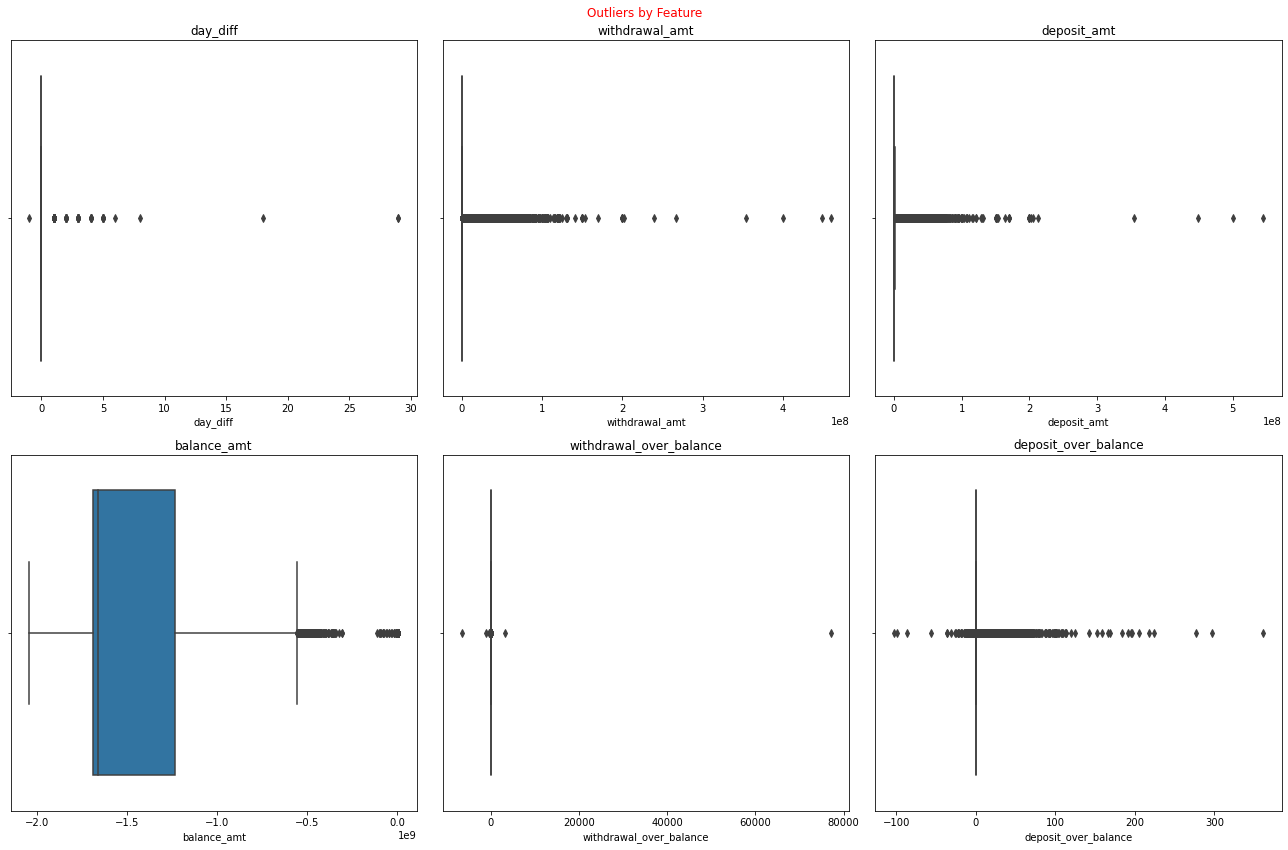

In [75]:
fig, axes = plt.subplots(2,3, sharex=False, figsize=(18, 12))
fig.suptitle('Outliers by Feature', color='r' )

for i in range(2):
    for j in range(3):
        sns.boxplot(ax=axes[i,j], x= features[3*i + j], data = bank)
        axes[i,j].set_title(f'{features[3*i + j]}')

plt.tight_layout()
plt.show()

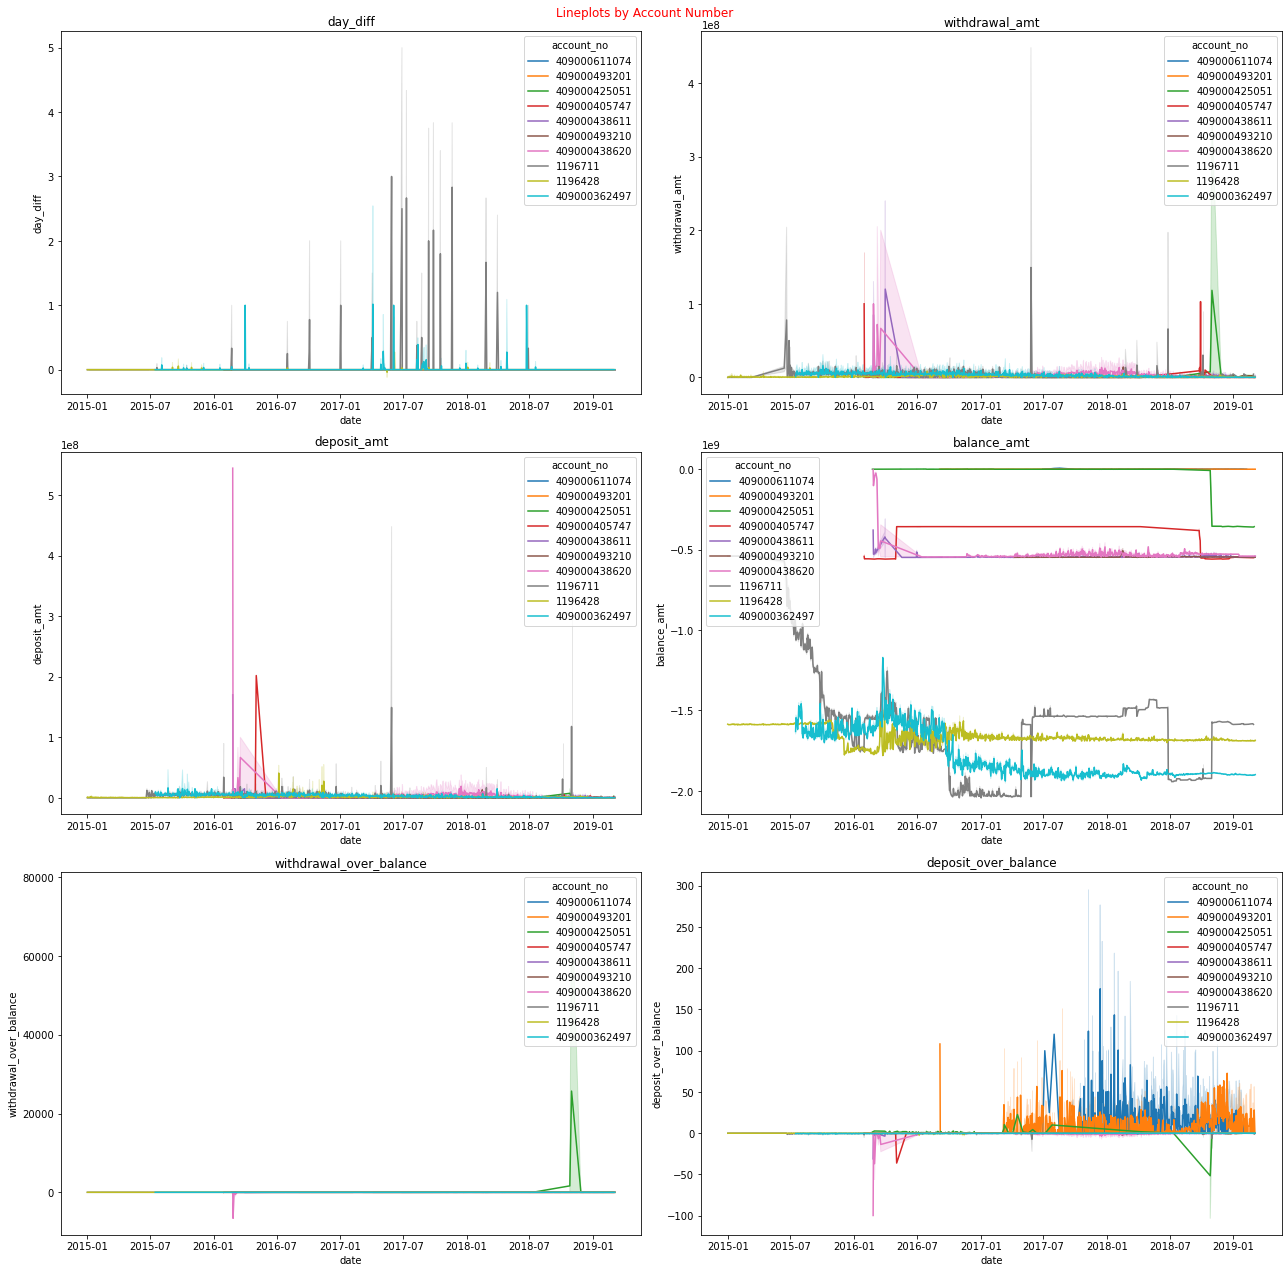

In [76]:
features = ['day_diff', 'withdrawal_amt', 'deposit_amt', 'balance_amt', 'withdrawal_over_balance', 'deposit_over_balance']
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18, 18))
fig.suptitle('Lineplots by Account Number', color='r' )

for i in range(3):
    for j in range(2):
        sns.lineplot(ax=axes[i,j], y= features[2*i + j], x = 'date', data = bank, hue = 'account_no')
        axes[i,j].set_title(f'{features[2*i + j]}')

plt.tight_layout()
plt.show()

## 3. Anomaly Detection

Before getting started with the anomaly detection we need to convert categorical variable into dummy/indicator variables. 

In [78]:
bank_premodel = bank.copy()

In [79]:
bank = pd.get_dummies(bank, columns = ['account_no'])

In [82]:
bank.head(3)

,date,value_date,day_diff,weekend_date,weekend_value_date,withdrawal_amt,deposit_amt,balance_amt,withdrawal_over_balance,deposit_over_balance,...,account_no_1196428,account_no_1196711,account_no_409000362497,account_no_409000405747,account_no_409000425051,account_no_409000438611,account_no_409000438620,account_no_409000493201,account_no_409000493210,account_no_409000611074
0,2017-06-29,2017-06-29,0,0,0,0.0,1000000.0,1000000.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,2017-07-05,2017-07-05,0,0,0,0.0,1000000.0,2000000.0,0.0,100.0,...,0,0,0,0,0,0,0,0,0,1
2,2017-07-18,2017-07-18,0,0,0,0.0,500000.0,2500000.0,0.0,25.0,...,0,0,0,0,0,0,0,0,0,1


In [86]:
(bank.weekend_date + bank.weekend_value_date).value_counts()

0    106140
2     10047
1        14
dtype: int64

### i. Isolation Forest Anomaly Detection

- Isolation Forest returna the anomaly score of each sample using the IsolationForest algorithm. 

- The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

- Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

- This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

- Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

link : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

### v. Clustering-Based Anomaly Detection

In [146]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

In [147]:
bank_clstr = bank.drop(columns=['date', 'value_date'], axis=1) 
scaler = StandardScaler()
bank_scaled = scaler.fit_transform(bank_clstr)

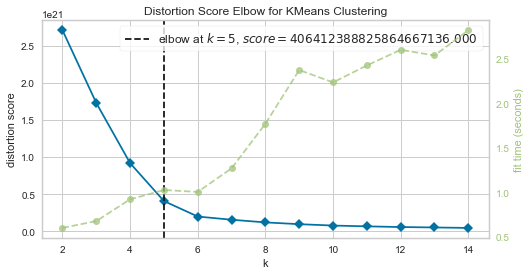

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [148]:
# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,15))
plt.figure(figsize=(8,4)).patch.set_facecolor('xkcd:white')
visualizer.fit(bank_clstr)       # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [149]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(bank_clstr)

KMeans(n_clusters=5)

Let's visualise labeled clusters.

Text(0.5, 0, 'balance_amt')

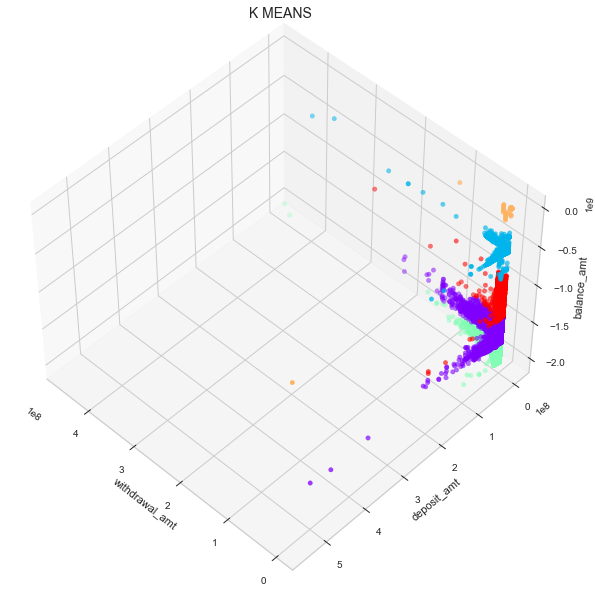

In [150]:
from mpl_toolkits.mplot3d import Axes3D
labels = kmeans.labels_

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_clstr.iloc[:,3], bank_clstr.iloc[:,4], bank_clstr.iloc[:,5], c=labels.astype(np.float), cmap='rainbow')
ax.set_title('K MEANS', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')

To overcome the curse of dimensionality, we need to figure out which components we want to keep.

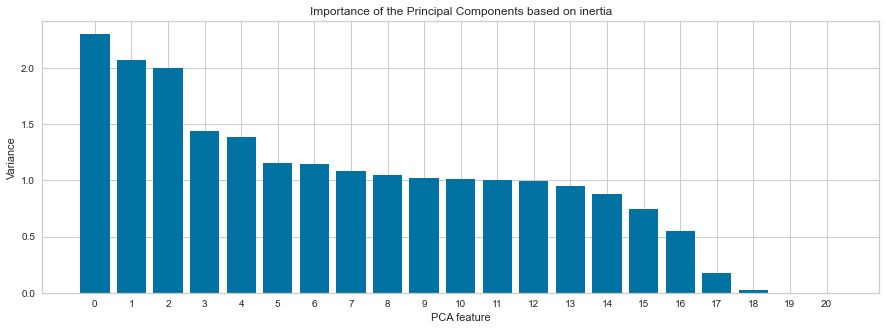

In [151]:
# Standardize/scale the dataset and apply PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# Extract the names of the numerical columns
x = bank_clstr
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()


In [152]:
bank_clstr.columns[:11]

Index(['day_diff', 'weekend_date', 'weekend_value_date', 'withdrawal_amt',
       'deposit_amt', 'balance_amt', 'withdrawal_over_balance',
       'deposit_over_balance', 'details_null_penalty',
       'details_numbers_penalty', 'cheque_penalty'],
      dtype='object')

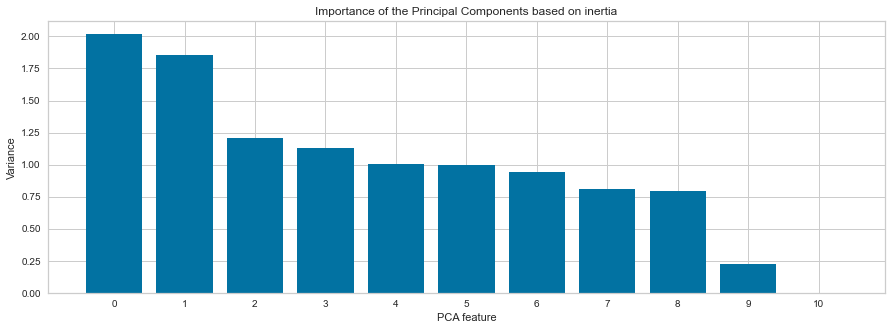

In [153]:
bank_gen = bank_clstr[bank_clstr.columns[:11]]

# Extract the names of the numerical columns
x = bank_gen
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

It turns out that even a data frame without customer columns PCA does not help too much in our case.

In K-Means Clustering approach to anomaly detection we calculate the distance between each point and its nearest centroid and the biggest distances are considered as anomaly. We are going to take following steps:

- We assume a proportion of data as outliers (outliers_fraction: proportion of the outliers present in our data set) and calculate number_of_outliers using outliers_fraction.
- We set a threshold as the minimum distance of these outliers.
- After labeling (0:normal, 1:anomaly) anomalies we will visualize them.

In [163]:
def getDistanceByPoint(data, model):
    """ Function that calculates the distance between a point and centroid of a cluster, 
            returns the distances in pandas series"""
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

bank_scaled = pd.DataFrame(bank_scaled, columns=bank_clstr.columns)
kmeans = KMeans(n_clusters=5)
kmeans.fit(bank_scaled)
labels = kmeans.predict(bank_scaled)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

# Assume that 0.5% of the entire data set are anomalies 
outliers_fraction = 0.005
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(bank_scaled, kmeans)
# number of observations that equate to the 13% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 13% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
bank_scaled['anomaly_kmeans'] = (distance >= threshold).astype(int)

In [164]:
bank_scaled.anomaly_kmeans.value_counts()

0    115620
1       581
Name: anomaly_kmeans, dtype: int64

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
colors = {0:'blue', 1:'red'}
ax.scatter(bank_scaled)

Text(0.5, 0, 'balance_amt')

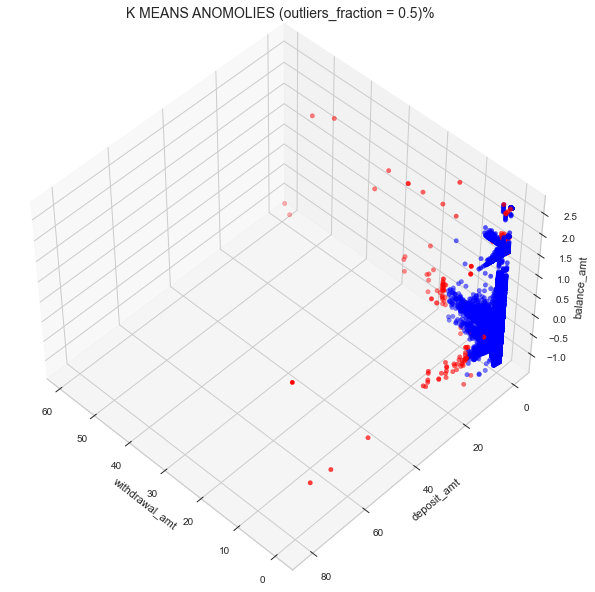

In [169]:
labels = bank_scaled.anomaly_kmeans
colors = {0:'blue', 1:'red'}

fig = plt.figure(1, figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(bank_scaled.iloc[:,3], bank_scaled.iloc[:,4], bank_scaled.iloc[:,5], c=labels.apply(lambda x:colors[x]))
ax.set_title(f'K MEANS ANOMOLIES (outliers_fraction = {100*outliers_fraction})%', fontsize=14)
ax.set_xlabel('withdrawal_amt')
ax.set_ylabel('deposit_amt')
ax.set_zlabel('balance_amt')